![data-x](http://oi64.tinypic.com/o858n4.jpg)


# Breakout Lecture 7: CATS vs DOGS 
#### Small training sample convolutional neural net

**Author:** Alexander Fred Ojala
**Sources:** 
* **Data**: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (subset, note all images are unique cat and dog photos)
* **Training + explanations**: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

**Download data and notebook here:** https://github.com/alexanderfo/data-x_public (place everything in the same folder)

**Copright:** Feel free to do whatever you want with this code.

___

# Required data
## Download image data, features, models and notebook here:
https://github.com/alexanderfo/data-x_public (place everything in the same folder)

## Downlad vgg16_weights.h5 (same weight file as last lecture, copy to same folder)
From **bCourses** or here: https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing
____

# Document outline (clickable links)
___

### [0: Image data logistics & package imports](#sec0)

#### **RUN THIS SECTION FIRST!**
In part 0 we read in the required modules, libraries and packages. We define varibales used throughout in the analysis, look at the data structure (train, validation, test, and try sets).

### [1: Extract bottleneck features from a pre-trained network: 90% accuracy in 1 / 10 mins (GPU / CPU)](#sec1)

Use the bottleneck features from a pretrained network (VGG16) in order to acheive ~90% accuracy on cat vs dog classification. Extraction of the bottleneck features takes ~10minutes on a CPU, this has been done for you.
* **Features names:** 
    * *features_train.npy* (1000 cats, 1000 dogs), 
    * *features_validation.npy* (400 cats, 400 dogs), 
    * *try_features.npy* (100 mixed cats and dogs)

### [2: Train model, make predictions and determine accuracy](#sec2)

Train the model, validate accuracy and make predicitons on unlabeled data. 


### [Appendix: Training a small convnet from scratch: 80% accuracy in 40 lines of code](#sec3)

This is not part of the breakout, but here we show how to implement a CNN from scratch and train it using only 2000 images (1000 per class). Takes about ~2.5hrs to run from scratch, this is pre-run for you if you want to play with it. We also show how Keras can augment a picture to never show the same picture twice to the CNN.

* **Model filename:** mod_appendix.json
* **Weights filename:** w_appendix.h5

<a id='sec0'></a>
# Part 0
## Image data logistics and package imports


In [1]:
!ls

NOTEBOOK-data-x_breakout7_cnn.ipynb
SOLUTIONS-NOTEBOOK-data-x_breakout7_cnn.ipynb
data
features_test.npy
features_train.npy
features_validation.npy
mod_appendix.json
w_appendix.h5


<center>The files you should have are:</center>

| Files                               |  Files                  |
| ----------------------------------- | ----------------------- |
| NOTEBOOK-data-x_breakout7_cnn.ipynb | features_validation.npy |
| data                                | mod_appendix.json       |
| features_test.npy                   | vgg16_weights.h5        |
| features_train.npy                  | w_appendix.h5           |

In [2]:
# Look at files, note all cat images and dog images are unique
from __future__ import absolute_import, division, print_function
import os
for path, dirs, files in os.walk('./data'):
    print('FOLDER',path)
    for f in files[:4]:
        print(f)

FOLDER ./data
FOLDER ./data/test
FOLDER ./data/test/catvdog
try001.jpg
try002.jpg
try003.jpg
try004.jpg
FOLDER ./data/train
FOLDER ./data/train/cats
cat0001.jpg
cat0002.jpg
cat0003.jpg
cat0004.jpg
FOLDER ./data/train/dogs
dog0001.jpg
dog0002.jpg
dog0003.jpg
dog0004.jpg
FOLDER ./data/validation
FOLDER ./data/validation/cats
cat001001.jpg
cat001002.jpg
cat001003.jpg
cat001004.jpg
FOLDER ./data/validation/dogs
dog001001.jpg
dog001002.jpg
dog001003.jpg
dog001004.jpg


In [3]:
print('Number of cat training images:', len(os.walk('./data/train/cats').next()[2]))
print('Number of dog training images:', len(os.walk('./data/train/dogs').next()[2]))
print('Number of cat validation images:', len(os.walk('./data/validation/cats').next()[2]))
print('Number of dog validation images:', len(os.walk('./data/validation/dogs').next()[2]))
print('Number of uncategorized test images:', len(os.walk('./data/test/catvdog').next()[2]))

# There should be 1000 train cat images, 1000 train dogs, 400 validation cats, 400 validation dogs, 100 uncategorized

Number of cat training images: 1000
Number of dog training images: 1000
Number of cat validation images: 400
Number of dog validation images: 400
Number of uncategorized test images: 100


In [4]:
# Define variables
TRAIN_DIR = './data/train/'
VAL_DIR = './data/validation/'
TEST_DIR = './data/test/' #one mixed category

img_width, img_height = 150, 150

n_train_samples = 2000
n_validation_samples = 800
n_epoch = 30
n_test_samples = 100

In [5]:
# Set theano backend
# see ~/.keras/keras.json and / or https://keras.io/backend/#switching-from-one-backend-to-another
!KERAS_BACKEND=theano python -c "from keras import backend"
from keras import backend as K
K.set_image_dim_ordering('th')

Using Theano backend.


Using Theano backend.


In [6]:
# Import relevant packages
import h5py
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import model_from_json
from keras.preprocessing import image

from IPython.display import Image, display

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

<a id='sec1'></a>
# Part 1
### Using the bottleneck features of a pre-trained network: 90% accuracy in 1 min (GPU) / 10 mins (CPU)

In Part 1 we leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset -- that Kevin showed in Lecture 6. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well (Kevin showed that in Lecture 6). The method presented here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Here's what the VGG16 architecture looks like:

![Image of Yaktocat](https://blog.keras.io/img/imgclf/vgg16_original.png)


**Our strategy will be as follows:** We will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training, validation and test data once, recording the output (the "bottleneck features" from the VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays.

Then we will train a small fully-connected model on top of the stored features.

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note, therefore we will not use data augmentation.

We won't review how the model is built and loaded -- this is outside the scope of the class. You can find it in multiple Keras examples already.

In [7]:
#  Run model once to record the bottleneck features using image data generators:

def save_bottleneck_features():

    # build the VGG16 network
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # load the weights of the VGG16 networks
    # note: when there is a complete match between your model definition
    # and your weight savefile, you can simply call model.load_weights(filename)
    assert os.path.exists('vgg16_weights.h5'), 'Model weights not found (Download file vgg16_weights.h5).'
    f = h5py.File('vgg16_weights.h5')
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print('Model loaded.')

    
    # Rescale value we multiply the data before any other processing. 
    # Our original images consist in RGB coefficients in the 0-255, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
        '''
        This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of image rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)
       '''
        print('Generate '+name_str+' image features')

        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)
        
        features = model.predict_generator(generator, n_samples)
        np.save(open('features_'+name_str+'.npy', 'w'), features) # save bottleneck features to file
        
    generate_features(TRAIN_DIR, n_train_samples, 'train')
    generate_features(VAL_DIR, n_validation_samples, 'validation')
    generate_features(TEST_DIR, n_test_samples, 'test')


    
#save_bottleneck_features()
'''
This part has been run for you
The features can be found in the files
'''
''

''

<a id='sec2'></a>
# Part 2: Breakout problems

## Problem 1 (Train model, record accuracy)

In [8]:
# Preface:
# Obtain class labels and binary classification for validation data
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

val_labels = val_gen.classes

print('\nClassifications:\n',val_gen.class_indices)
print('\nClass labels:\n',val_labels)

Found 800 images belonging to 2 classes.

Classifications:
 {'cats': 0, 'dogs': 1}

Class labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

In [9]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data


train_data = np.load(open('features_train.npy'))
train_labels = np.array([0] * (n_train_samples // 2) + [1] * (n_train_samples // 2))

validation_data = np.load(open('features_validation.npy'))
# same as val_labels above
validation_labels = np.array([0] * (n_validation_samples // 2) + [1] * (n_validation_samples // 2))

# Add top layers trained ontop of extracted VGG features
# Small fully connected model trained on top of the stored features
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

'''
#We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
#To go with it we will also use the binary_crossentropy loss to train our model.

'''
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels,
          nb_epoch=n_epoch, batch_size=32,
          validation_data=(validation_data, validation_labels)) # fit the model
print('Done!')

Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 1s - loss: 0.8397 - acc: 0.7325 - val_loss: 0.4955 - val_acc: 0.7612
Epoch 2/30
2000/2000 [==============================] - 2s - loss: 0.3870 - acc: 0.8260 - val_loss: 0.2690 - val_acc: 0.9025
Epoch 3/30
2000/2000 [==============================] - 1s - loss: 0.3097 - acc: 0.8680 - val_loss: 0.3653 - val_acc: 0.8325
Epoch 4/30
2000/2000 [==============================] - 1s - loss: 0.2785 - acc: 0.8910 - val_loss: 0.2628 - val_acc: 0.9025
Epoch 5/30
2000/2000 [==============================] - 2s - loss: 0.2062 - acc: 0.9195 - val_loss: 0.8885 - val_acc: 0.6937
Epoch 6/30
2000/2000 [==============================] - 2s - loss: 0.2026 - acc: 0.9220 - val_loss: 0.4792 - val_acc: 0.8425
Epoch 7/30
2000/2000 [==============================] - 4s - loss: 0.1863 - acc: 0.9205 - val_loss: 0.7341 - val_acc: 0.7462
Epoch 8/30
2000/2000 [==============================] - 4s - loss: 0.1601 - ac

**Question:** What was the validation accuracy for the last training epoch, and how is it that we can reach such high accuracy with such small amount of data in a short amount of time?

**Answer:** We reach a validation accuracy of 0.87-0.91: not bad at all. This is definitely partly due to the fact that the base model was trained on a dataset that already featured dogs and cats (among hundreds of other classes).

## Problem 2: Validate accuracy and make predictions on unlabeled data


In [10]:
# Problem 2
# Use the model trained in Problem 1 to determine the accuracy on the validation data set
#
# Hint: Use keras model methods predict, predict_classes, predict_proba


In [11]:
## ANSWER Problem 2
val_pred_class = model.predict_classes(validation_data,verbose=0)
val_pred_prob = model.predict_proba(validation_data,verbose=0)

print('Accuracy on validation set: ',(val_pred_class.ravel()==val_labels).sum()/800.*100,'%')

Accuracy on validation set:  90.125 %


In [12]:
print(model.evaluate(validation_data,val_labels,verbose=0))
# First number is validation loss, loss of the objective function
# Second number validation accuracy

[0.56005944767734039, 0.90125]


**Answer:** The validation accuracy is 90.125% which is deemed to be equal to 0.9012, ie the val_acc at the last epoch of the training

## Problem 3: Print class predicition of unlabeled data

In [15]:
# Problem 3
# Use the model trained in Problem 1 to classify the test data images.
# Create a function that loads one image from the test data and then predicts
# if it is a cat or a dog and with what probability it thinks it is a cat or a dog
#
# Use variable test_data to make predictions
# Use list test_images to obtain the file name for all images (Note: test_images[0] corresponds to test_data[0])
# Use function plot_pic(img) to plot the image file

## Load in processed images feature to feed into bottleneck model

test_data = np.load(open('features_test.npy'))

test_images =  [TEST_DIR+'catvdog/'+img for img in os.listdir(TEST_DIR+'catvdog/')]

def read_image(file_path):
    # For image visualization
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_CUBIC)

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()



I think this is a CAT with 56.40199% probability


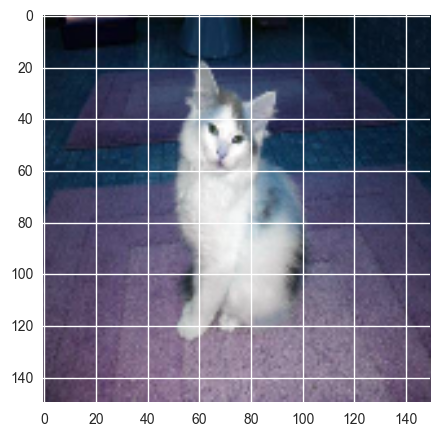



I think this is a CAT with 99.94696% probability


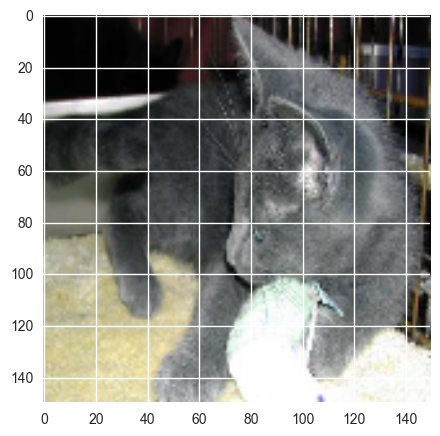



I think this is a CAT with 100.0% probability


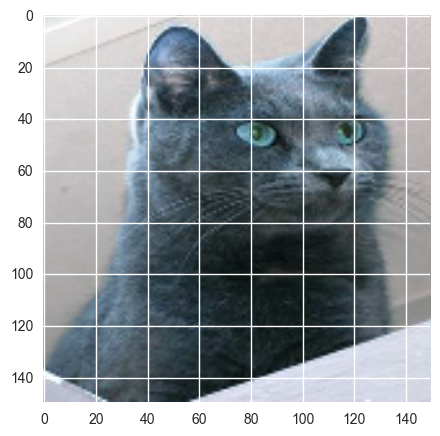



I think this is a DOG with 100.0% probability


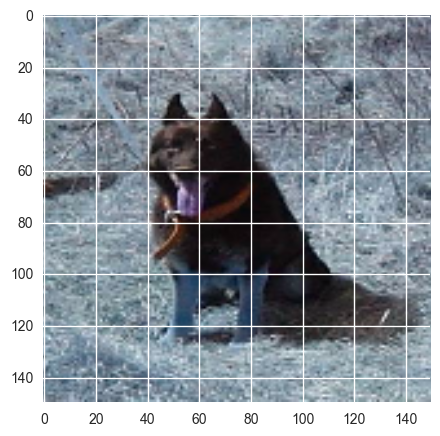



I think this is a CAT with 100.0% probability


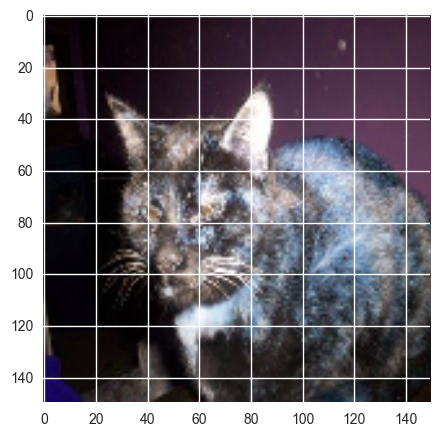



I think this is a CAT with 99.96272% probability


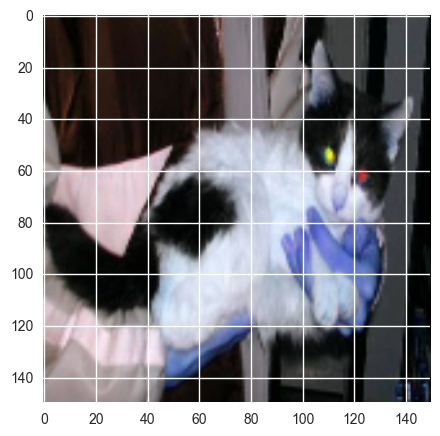



I think this is a CAT with 99.99998% probability


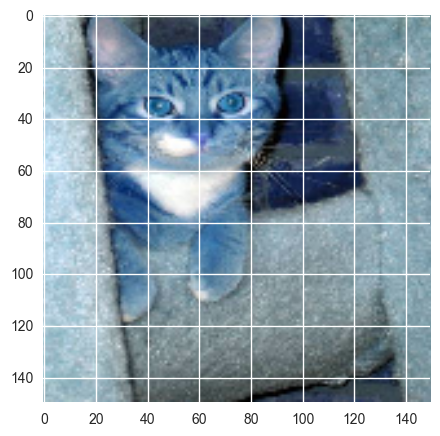



I think this is a CAT with 99.99991% probability


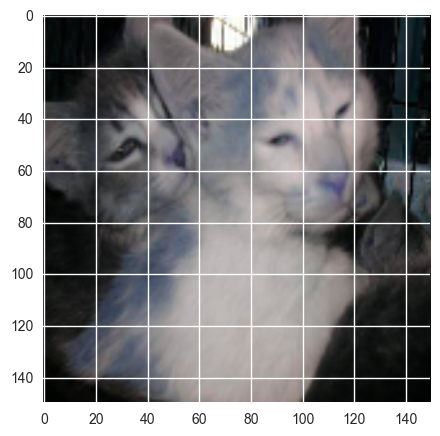



I think this is a DOG with 100.0% probability


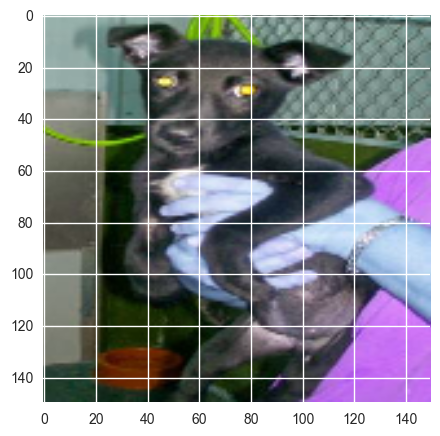



I think this is a DOG with 100.0% probability


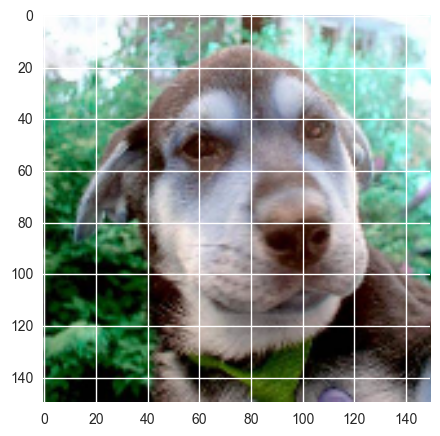



I think this is a CAT with 99.99982% probability


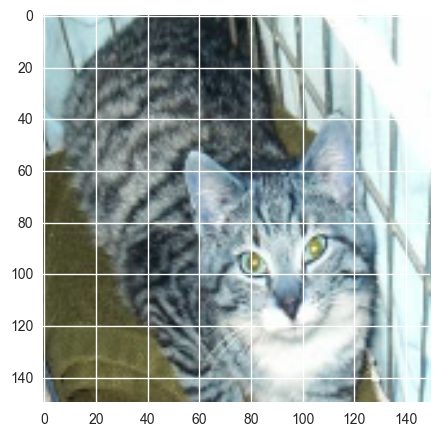



I think this is a DOG with 100.0% probability


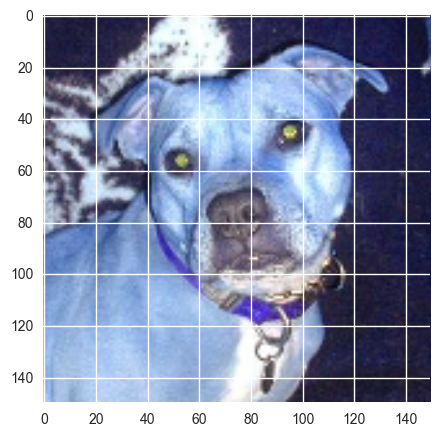



I think this is a CAT with 99.99999% probability


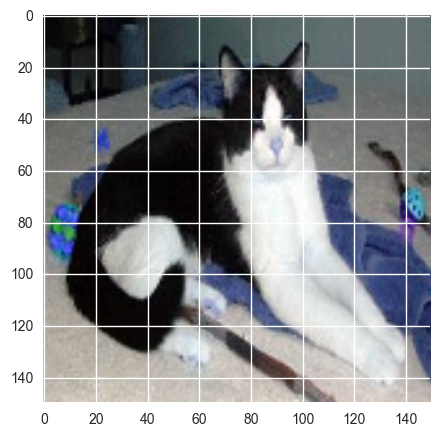



I think this is a DOG with 100.0% probability


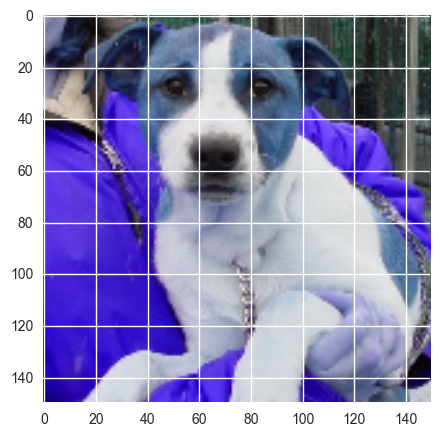



I think this is a CAT with 99.707% probability


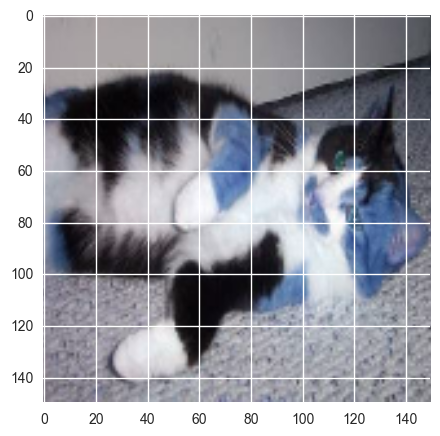



I think this is a DOG with 100.0% probability


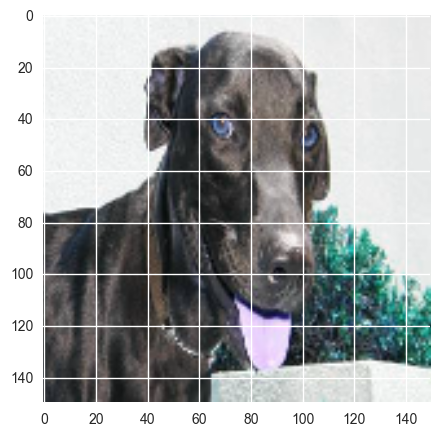



I think this is a DOG with 100.0% probability


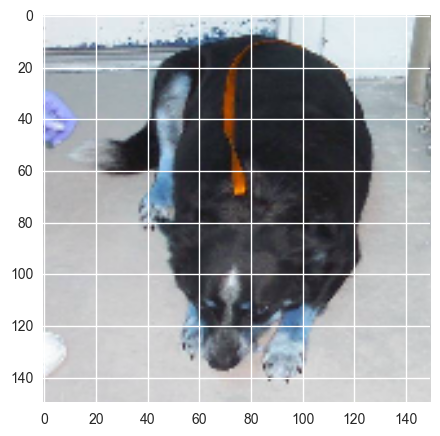



I think this is a CAT with 99.99304% probability


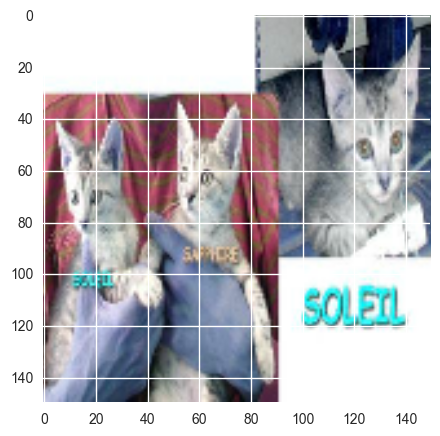



I think this is a DOG with 100.0% probability


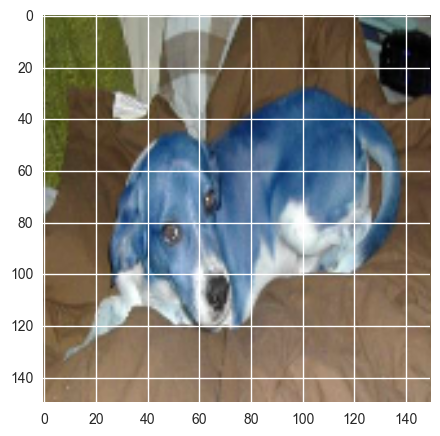

In [16]:
## Answer
def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        class_pred = mod.predict_classes(test_data,verbose=0)[idx]
        prob_pred = mod.predict_proba(test_data,verbose=0)[idx]
        
        if class_pred ==0:
            prob_pred = 1-prob_pred
            class_guess='CAT'
        else:
            class_guess='DOG'
        
        print('\n\nI think this is a ' + class_guess + ' with ' +str(round(float(prob_pred)*100,5)) + '% probability')
        plot_pic(test_images[idx])

predict(model,r=range(1,20))

<a id='sec3'></a>
# Appendix: Training a small convnet from scratch: 80% accuracy in 40 lines of code

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

The code snippet below is our first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

configure random transformations and normalization operations to be done on your image data during training
instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [ ]:
# Import image data generator

datagen = ImageDataGenerator(
        rotation_range=40, #rotation_range degrees (0-180), range that randomly rotate pictures
        width_shift_range=0.2, #width_shift range (fraction of total width) within which to randomly translate pic
        height_shift_range=0.2, # -ii-
        
        #rescale value we multiply the data before any other processing. 
        #Our original images consist in RGB coefficients in the 0-255, 
        #but such values would be too high for our models to process (given typical learning rate), 
        # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
        rescale=1./255,
        
        #randomly applying shearing transformations (shear mapping is a linear map that 
        #displaces each point in fixed direction, by an amount proportional to its 
        #signed distance from a line that is parallel to that direction)
        shear_range=0.2, 
        zoom_range=0.2, #randomly zooming inside pictures
        
        #is for randomly flipping half of the images horizontally 
        #--relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).

        horizontal_flip=True,
    
        #is the strategy used for filling in newly created pixels, 
        #which can appear after a rotation or a width/height shift.
        fill_mode='nearest')

Now let's start generating some pictures using this tool and save them to a temporary directory, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable:

In [ ]:
img = load_img(TRAIN_DIR+'cats/cat0001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0

if not os.path.exists('preview'):
    os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

prev_files = os.walk('./preview').next()[2]
print(prev_files[:4])

for img in prev_files[1:4]:
    print('Image '+img)
    display(Image(filename='preview/'+img))

In [ ]:
def first_model():

    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(3, img_height, img_width)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    '''
    On top of it we stick two fully-connected layers. 
    We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
    To go with it we will also use the binary_crossentropy loss to train our model.
    '''

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    
    # Let's prepare our data. We will use .flow_from_directory()
    # to generate batches of image data (and their labels) directly from our jpgs in their respective folders.
    
    # Below is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    print('Train generator')
    train_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,  # this is the target directory
            target_size=(img_height, img_width),  # all images will be resized to 150x150
            batch_size=32,
            class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

    # this is a similar generator, for validation data
    print('Validation generator')
    validation_generator = test_datagen.flow_from_directory(
            VAL_DIR,
            target_size=(img_height, img_width),
            batch_size=32,
            class_mode='binary')
    

    
    return model, train_generator, validation_generator

In [ ]:
# Look at class indices from our generators


_, train_gen,val_gen =first_model()
print('')
print(val_gen.class_indices)
print(val_gen.classes)

In [ ]:
# Define and fit the first model
n_epoch = 50
def fit_first_model():

    mod1, train_generator, validation_generator = first_model()
    mod1.fit_generator(
            train_generator,
            samples_per_epoch=n_train_samples,
            nb_epoch=n_epoch,
            validation_data=validation_generator,
            nb_val_samples=n_validation_samples)

    # save model to disk
    mod1.save_weights('w_appendix.h5')  # always save your weights after training or during training
    model_json = mod1.to_json()
    with open("mod_appendix.json", "w") as json_file:
        json_file.write(model_json)
    print("Saved model to disk")

#fit_first_model()


### DONE ###

In [ ]:
# FIRST MODEL EXPLORATION

# load model 1 and weights

json_file = open('mod_appendix.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
mod1 = model_from_json(loaded_model_json)
# load weights into new model
mod1.load_weights("w_appendix.h5")
print("Loaded model from disk")

mod1.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

# Extract image features from test set - to make predictions

datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
val_generator = datagen.flow_from_directory( VAL_DIR, target_size=(img_height, img_width),
                                              batch_size=32,class_mode='binary')

preds = mod1.evaluate_generator(val_generator,n_validation_samples)

print('\nModel 1 accuracy on 800 validation images:', round(sum(preds)/2,4)*100,'%')

In [ ]:
# Plot picture and print class prediction on cats vs dogs (unsorted)


try_images =  [TEST_DIR+'catvdog/'+img for img in os.listdir(TEST_DIR+'catvdog/')]

def read_image(file_path):
    # For image visualization
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_CUBIC)

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()

def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        
        img_path = try_images[idx]
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        class_pred = mod.predict_classes(x,verbose=0)
        
        if class_pred == 0:
            class_guess='CAT'
        else:
            class_guess='DOG'
        
        print('\n\nI think this is a ' + class_guess)
        plot_pic(try_images[idx])

predict(mod1,r=range(1,10))